# Trabalho Computacional 2. Perceptron Multicamada no problema MNIST

Nome: Antonio Leonardo Souto Gomes
Matrícula: 211027607

## 1. Introdução e Preparação

O conjunto de dados MNIST (Modified National Institute of Standards and Technology) representa uma coleção fundamental de dígitos manuscritos, amplamente reconhecida como um ponto de referência para a avaliação e comparação de algoritmos de aprendizado de máquina, especialmente no domínio da classificação de imagens. É frequentemente considerado o "Hello World" do aprendizado profundo para tarefas de imagem devido à sua natureza direta e uso generalizado.

O primeiro passo é importar o que é necessário para execução do programa:

In [1]:
%matplotlib inline
import torch
import torchvision
from torchvision import transforms
from d2l import torch as d2l
from torch import nn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

Após isso, definiremos nosso dataset, o MNIST, que já está disponível como um dos conjuntos de dados do pytorch, o dataloader e textelabels:

In [2]:
class MNIST(d2l.DataModule):  #@save
    """The MNIST dataset."""
    def __init__(self, batch_size=64, resize=(28, 28)):
        super().__init__()
        self.save_hyperparameters()
        trans = transforms.Compose([transforms.Resize(resize),
                                    transforms.ToTensor()])
        self.train = torchvision.datasets.MNIST(
            root=self.root, train=True, transform=trans, download=True)
        self.val = torchvision.datasets.MNIST(
            root=self.root, train=False, transform=trans, download=True)

    def get_dataloader(self, train):
        data = self.train if train else self.val
        return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                           num_workers=self.num_workers)

    def text_labels(self, indices):
        """Return text labels."""
        return [self.train.classes[int(i)] for i in indices]

O dataset MNIST conta com 60000 exemplos de treinamento e também 10000 de treinamento, cada exemplo é uma matriz de 28x28 pixels, de imagens pré-processadas. Podemos conferir com:

In [3]:
dataset = MNIST()
print(f"Dados de treino: {len(dataset.train)}, dados de validação: {len(dataset.val)}")

Dados de treino: 60000, dados de validação: 10000


Abaixo um código, do d2l, para ler um minibatch de um dado tamanho. Em cada chamada, ele nos dá o tensor de entrada X e a classe desejada y. Ele também embaralha os dados no momento do treinamento.

In [4]:
X, y = next(iter(dataset.train_dataloader()))

A seguir definiremos um código para avaliar a acurácia do programa:

In [5]:
def evaluate_accuracy(model, data_iter):
    model.eval()
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(d2l.accuracy(model(X), y), y.numel())
    model.train()
    return metric[0] / metric[1]

### 2a) Perceptron com uma camada escondida, função de ativação sigmoide e otimização por descida de gradiente.

Para a primeira abordagem, utilizaremos a função de ativação sigmoide e a otimização por descida do gradiente (SGD):

- A sigmoide é caracterizada por uma curva suave em forma de "S", ela mapeia qualquer número real para um valor entre 0 e 1. Isso a torna particularmente útil para representar probabilidades de um determinado resultado
- A otimização por Descida de Gradiente (Gradient Descent) é um algoritmo fundamental em aprendizado de máquina e redes neurais para minimizar uma função de custo (ou função de perda). O objetivo é encontrar os parâmetros (pesos e vieses) do modelo que resultam no menor erro possível.

Comecemos com um MLP com uma camada escondida de 128 neurônios. Usaremos a função logística (sigmoide) como função de ativação na camada escondida e softmax na camada de saída (lembre que a camada de saída pode na verdade ser declarada linear, pois o pytorch já aplica o softmax na implementação da função de custo de entropia cruzada, como vimos em sala). Mantenha entropia cruzada como função de custo e a descida simples de gradiente como otimizador.

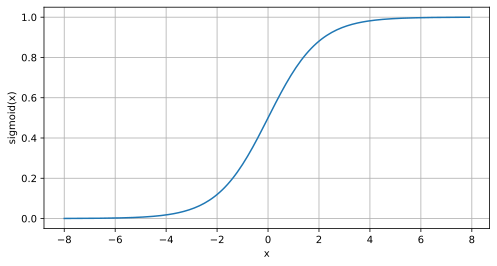

In [6]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(8, 4))

A seguir, através dos parametros definidos, treinaremos um modelo com essas características: 

Acurácia final(SGD, Sigmoid, 128 hidden): 0.9152


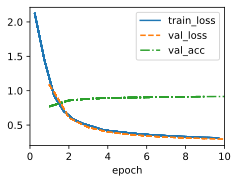

In [7]:
class MLP_Sigmoid_SGD(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(),
                                 nn.LazyLinear(num_hiddens),
                                 nn.Sigmoid(),  # Sigmoid activation
                                 nn.LazyLinear(num_outputs))

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)

data = MNIST(batch_size=256)
model_sgd_sigmoid = MLP_Sigmoid_SGD(num_outputs=10, num_hiddens=128, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model_sgd_sigmoid, data)

print(f"Acurácia final(SGD, Sigmoid, 128 hidden): {evaluate_accuracy(model_sgd_sigmoid, data.val_dataloader()):.4f}")

### 2b) Otimizador Adam

O gradiente simples tem um inconveniente grave: sabemos que melhoramos o desempenho do classificador se acompanharmos o gradiente em um "pequeno passo", mas não é fácil determinar que passo deveria ser esse. E sabemos que ele deveria variar ao longo do treinamento. Várias propostas para uma adaptação da taxa de aprendizado foram feitas, mas a que acabou se tornando padrão é o chamado otimizador Adam (Kingma and Ba, 2014). O nome vem de "Estimativa adaptativa de momentos". Acompanhando a média e variância do gradiente entre atualizações, ele consegue adaptar a taxa de aprendizado, e torná-la diferente para cada parâmetro.

É importante notar que o otimizador Adam também usa função sigmoide, então a seguir implementaremos esse modelo:

Acurácia final(Adam, Sigmoid, 128 hidden): 0.9608


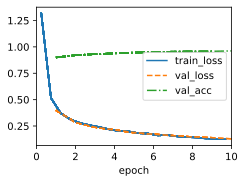

In [8]:
class MLP_Sigmoid_Adam(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(),
                                 nn.LazyLinear(num_hiddens),
                                 nn.Sigmoid(),  
                                 nn.LazyLinear(num_outputs))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

model_adam_sigmoid = MLP_Sigmoid_Adam(num_outputs=10, num_hiddens=128, lr=0.001) 
trainer.fit(model_adam_sigmoid, data)
print(f"Acurácia final(Adam, Sigmoid, 128 hidden): {evaluate_accuracy(model_adam_sigmoid, data.val_dataloader()):.4f}")

### 2c) A função Relu

A função de ativação ReLU (Rectified Linear Unit), ou Unidade Linear Retificada, é a função de ativação mais utilizada em redes neurais profundas atualmente. Ela se tornou popular devido à sua simplicidade e eficácia na superação de alguns problemas de funções de ativação mais antigas, como a sigmoide e a tangente hiperbólica (tanh).

Visualmente, o gráfico da ReLU é uma linha reta em y=0 para valores negativos de x, e uma linha reta com inclinação 1 para valores positivos de x.

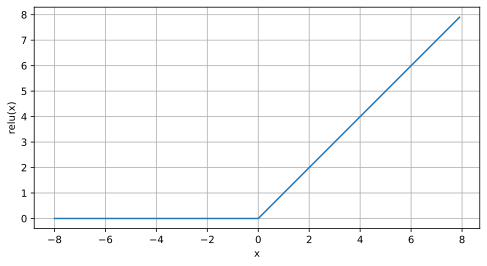

In [9]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(8, 4))

Acurácia final(Adam, ReLU, 128 hidden): 0.9740


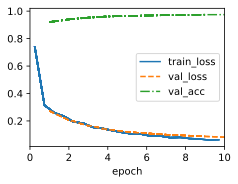

In [10]:
class MLP_ReLU_Adam(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(),
                                 nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), 
                                 nn.LazyLinear(num_outputs))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

model_relu_adam = MLP_ReLU_Adam(num_outputs=10, num_hiddens=128, lr=0.001)
trainer.fit(model_relu_adam, data)
print(f"Acurácia final(Adam, ReLU, 128 hidden): {evaluate_accuracy(model_relu_adam, data.val_dataloader()):.4f}")

### 2d) Redes maiores

Para redes maiores seguiremos algumas abordagens distintas: 

- Uma camada escondida com 256 neurônios;
- Uma rede com duas camadas escondidas;

#### Uma camada escondida com 256 neurônios

Acurácia final(Adam, ReLU, 256 hidden): 0.9783


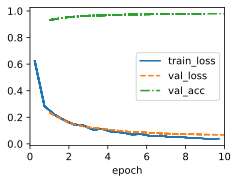

In [11]:
class MLP_ReLU_Adam_256(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(),
                                 nn.LazyLinear(num_hiddens),
                                 nn.ReLU(),
                                 nn.LazyLinear(num_outputs))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

model_relu_adam_256 = MLP_ReLU_Adam_256(num_outputs=10, num_hiddens=256, lr=0.001)
trainer.fit(model_relu_adam_256, data)
print(f"Acurácia final(Adam, ReLU, 256 hidden): {evaluate_accuracy(model_relu_adam_256, data.val_dataloader()):.4f}")

#### Uma rede com duas camadas escondidas

Acurácia final(Adam, ReLU, 256-128 hidden): 0.9797


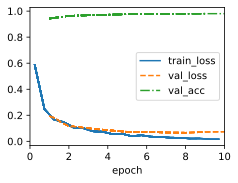

In [12]:
class MLP_Two_Hidden_Layers(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(),
                                 nn.LazyLinear(num_hiddens_1),
                                 nn.ReLU(),
                                 nn.LazyLinear(num_hiddens_2),
                                 nn.ReLU(),
                                 nn.LazyLinear(num_outputs))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

model_two_layers = MLP_Two_Hidden_Layers(num_outputs=10, num_hiddens_1=256, num_hiddens_2=256, lr=0.001)
trainer.fit(model_two_layers, data)
print(f"Acurácia final(Adam, ReLU, 256-128 hidden): {evaluate_accuracy(model_two_layers, data.val_dataloader()):.4f}")

# Visualização

Neste trecho, faremos a análise dos erros cometidos pelos modelos, bem como mostraremos (visualmente) alguns desses erros, isso nos permitirá fazer uma análise mais concisa sobre os erros cometidos pelos modelos, pois teremos outra métrica além da acurácia (a quantidade nominal de erros) para avaliarmos os modelos em questão

## Visualização do modelo sigmoide

In [13]:
misclassified_images = []
true_labels_misclassified = []
predicted_labels_misclassified = []

In [14]:
model_sgd_sigmoid.eval()
with torch.no_grad():
    for X, y_true in tqdm(data.val_dataloader(), desc="Analisando minibatches de validação"):
        logits = model_sgd_sigmoid(X)
        y_pred = torch.argmax(logits, axis=1)
        incorrect_indices = (y_pred != y_true).nonzero(as_tuple=True)[0]
        if len(incorrect_indices) > 0:
            for idx in incorrect_indices:
                misclassified_images.append(X[idx].squeeze().cpu().numpy())
                true_labels_misclassified.append(data.text_labels([y_true[idx]])[0])
                predicted_labels_misclassified.append(data.text_labels([y_pred[idx]])[0])

total_errors = len(misclassified_images)
print(f"\nTotal de erros de classificação encontrados no conjunto de validação: {total_errors}")

Analisando minibatches de validação: 100%|██████████████████████████████████████████████| 40/40 [00:00<00:00, 94.18it/s]


Total de erros de classificação encontrados no conjunto de validação: 848


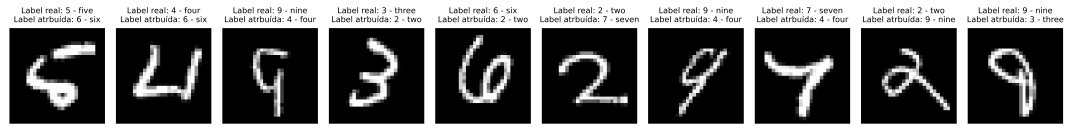

In [15]:
num_to_show = min(10, total_errors)
fig, axes = plt.subplots(1, num_to_show, figsize=(15, 3))
axes = axes.flatten() if num_to_show > 1 else [axes]

for i in range(num_to_show):
    ax = axes[i]
    ax.imshow(misclassified_images[i], cmap='gray')
    ax.set_title(f"Label real: {true_labels_misclassified[i]}\nLabel atrbuída: {predicted_labels_misclassified[i]}", fontsize=8)
    ax.axis('off')
plt.tight_layout()
plt.show()

## Visualização do modelo ADAM

In [16]:
misclassified_images = []
true_labels_misclassified = []
predicted_labels_misclassified = []

In [17]:
model_adam_sigmoid.eval()
with torch.no_grad():
    for X, y_true in tqdm(data.val_dataloader(), desc="Analisando minibatches de validação"):
        logits = model_adam_sigmoid(X)
        y_pred = torch.argmax(logits, axis=1)
        incorrect_indices = (y_pred != y_true).nonzero(as_tuple=True)[0]
        if len(incorrect_indices) > 0:
            for idx in incorrect_indices:
                misclassified_images.append(X[idx].squeeze().cpu().numpy())
                true_labels_misclassified.append(data.text_labels([y_true[idx]])[0])
                predicted_labels_misclassified.append(data.text_labels([y_pred[idx]])[0])

total_errors = len(misclassified_images)
print(f"\nTotal de erros de classificação encontrados no conjunto de validação: {total_errors}")

Analisando minibatches de validação: 100%|██████████████████████████████████████████████| 40/40 [00:00<00:00, 80.62it/s]


Total de erros de classificação encontrados no conjunto de validação: 392


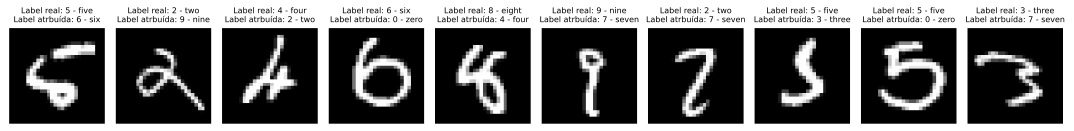

In [18]:
num_to_show = min(10, total_errors)
fig, axes = plt.subplots(1, num_to_show, figsize=(15, 3))
axes = axes.flatten() if num_to_show > 1 else [axes]

for i in range(num_to_show):
    ax = axes[i]
    ax.imshow(misclassified_images[i], cmap='gray')
    ax.set_title(f"Label real: {true_labels_misclassified[i]}\nLabel atrbuída: {predicted_labels_misclassified[i]}", fontsize=8)
    ax.axis('off')
plt.tight_layout()
plt.show()

## Visualização do modelo reLU

In [19]:
misclassified_images = []
true_labels_misclassified = []
predicted_labels_misclassified = []

In [20]:
model_relu_adam.eval()
with torch.no_grad():
    for X, y_true in tqdm(data.val_dataloader(), desc="Analisando minibatches de validação"):
        logits = model_relu_adam(X)
        y_pred = torch.argmax(logits, axis=1)
        incorrect_indices = (y_pred != y_true).nonzero(as_tuple=True)[0]
        if len(incorrect_indices) > 0:
            for idx in incorrect_indices:
                misclassified_images.append(X[idx].squeeze().cpu().numpy())
                true_labels_misclassified.append(data.text_labels([y_true[idx]])[0])
                predicted_labels_misclassified.append(data.text_labels([y_pred[idx]])[0])

total_errors = len(misclassified_images)
print(f"\nTotal de erros de classificação encontrados no conjunto de validação: {total_errors}")

Analisando minibatches de validação: 100%|██████████████████████████████████████████████| 40/40 [00:00<00:00, 89.35it/s]


Total de erros de classificação encontrados no conjunto de validação: 260


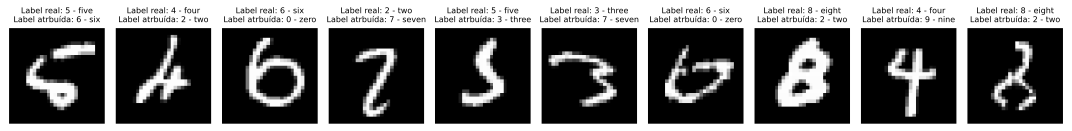

In [21]:
num_to_show = min(10, total_errors)
fig, axes = plt.subplots(1, num_to_show, figsize=(15, 3))
axes = axes.flatten() if num_to_show > 1 else [axes]

for i in range(num_to_show):
    ax = axes[i]
    ax.imshow(misclassified_images[i], cmap='gray')
    ax.set_title(f"Label real: {true_labels_misclassified[i]}\nLabel atrbuída: {predicted_labels_misclassified[i]}", fontsize=8)
    ax.axis('off')
plt.tight_layout()
plt.show()

## Visualização do modelo com 256 neurônios

In [22]:
misclassified_images = []
true_labels_misclassified = []
predicted_labels_misclassified = []

In [23]:
model_relu_adam_256.eval()
with torch.no_grad():
    for X, y_true in tqdm(data.val_dataloader(), desc="Analisando minibatches de validação"):
        logits = model_relu_adam_256(X)
        y_pred = torch.argmax(logits, axis=1)
        incorrect_indices = (y_pred != y_true).nonzero(as_tuple=True)[0]
        if len(incorrect_indices) > 0:
            for idx in incorrect_indices:
                misclassified_images.append(X[idx].squeeze().cpu().numpy())
                true_labels_misclassified.append(data.text_labels([y_true[idx]])[0])
                predicted_labels_misclassified.append(data.text_labels([y_pred[idx]])[0])

total_errors = len(misclassified_images)
print(f"\nTotal de erros de classificação encontrados no conjunto de validação: {total_errors}")

Analisando minibatches de validação: 100%|██████████████████████████████████████████████| 40/40 [00:00<00:00, 91.48it/s]


Total de erros de classificação encontrados no conjunto de validação: 217


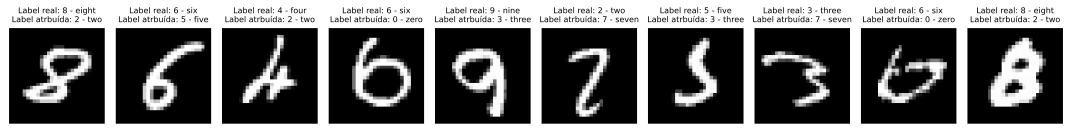

In [24]:
num_to_show = min(10, total_errors)
fig, axes = plt.subplots(1, num_to_show, figsize=(15, 3))
axes = axes.flatten() if num_to_show > 1 else [axes]

for i in range(num_to_show):
    ax = axes[i]
    ax.imshow(misclassified_images[i], cmap='gray')
    ax.set_title(f"Label real: {true_labels_misclassified[i]}\nLabel atrbuída: {predicted_labels_misclassified[i]}", fontsize=8)
    ax.axis('off')
plt.tight_layout()
plt.show()

## Visualização do modelo com duas camadas escondidas

In [25]:
misclassified_images = []
true_labels_misclassified = []
predicted_labels_misclassified = []

In [26]:
model_two_layers.eval()
with torch.no_grad():
    for X, y_true in tqdm(data.val_dataloader(), desc="Analisando minibatches de validação"):
        logits = model_two_layers(X)
        y_pred = torch.argmax(logits, axis=1)
        incorrect_indices = (y_pred != y_true).nonzero(as_tuple=True)[0]
        if len(incorrect_indices) > 0:
            for idx in incorrect_indices:
                misclassified_images.append(X[idx].squeeze().cpu().numpy())
                true_labels_misclassified.append(data.text_labels([y_true[idx]])[0])
                predicted_labels_misclassified.append(data.text_labels([y_pred[idx]])[0])

total_errors = len(misclassified_images)
print(f"\nTotal de erros de classificação encontrados no conjunto de validação: {total_errors}")

Analisando minibatches de validação: 100%|██████████████████████████████████████████████| 40/40 [00:00<00:00, 94.22it/s]


Total de erros de classificação encontrados no conjunto de validação: 203


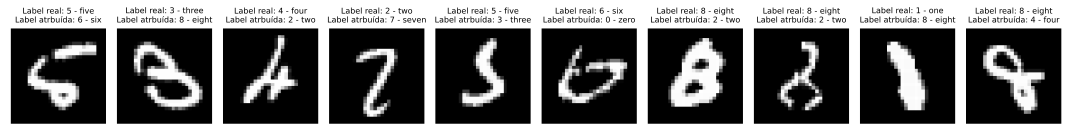

In [27]:
num_to_show = min(10, total_errors)
fig, axes = plt.subplots(1, num_to_show, figsize=(15, 3))
axes = axes.flatten() if num_to_show > 1 else [axes]

for i in range(num_to_show):
    ax = axes[i]
    ax.imshow(misclassified_images[i], cmap='gray')
    ax.set_title(f"Label real: {true_labels_misclassified[i]}\nLabel atrbuída: {predicted_labels_misclassified[i]}", fontsize=8)
    ax.axis('off')
plt.tight_layout()
plt.show()

# Matriz de confusão

Assim como no trecho anterior, introduziremos um elemento visando aprofundar o nível da análise dos modelos. A matriz de confusão traz informações acerca das erros mais comuns.

## Matriz de confusão do modelo sigmoide

In [28]:
all_true_labels = torch.tensor([])
all_predicted_labels = torch.tensor([]) 

In [29]:
with torch.no_grad():
    for X, y_true in tqdm(data.val_dataloader(), desc="Coletando previsões para a matriz de confusão"):
        logits = model_sgd_sigmoid(X)
        y_pred = torch.argmax(logits, axis=1)

        all_true_labels = torch.cat((all_true_labels, y_true), dim=0)
        all_predicted_labels = torch.cat((all_predicted_labels, y_pred), dim=0)

model_sgd_sigmoid.train()

all_true_labels_cpu = all_true_labels.cpu().numpy()
all_predicted_labels_cpu = all_predicted_labels.cpu().numpy()

cm = confusion_matrix(all_true_labels_cpu, all_predicted_labels_cpu)
print("\nMatriz de Confusão (10x10):")
print(cm)

Coletando previsões para a matriz de confusão: 100%|████████████████████████████████████| 40/40 [00:00<00:00, 94.40it/s]


Matriz de Confusão (10x10):
[[ 959    0    4    2    0    4    7    1    3    0]
 [   0 1103    2    2    1    2    4    1   20    0]
 [  12    6  917   15   15    2   13   12   35    5]
 [   3    1   22  908    0   32    3   15   17    9]
 [   1    3    5    1  913    1   11    2    5   40]
 [  10    3    6   41   10  769   14    9   23    7]
 [  15    3    5    1   15   17  898    1    3    0]
 [   4   12   25    4    7    0    0  940    3   33]
 [   9    9    8   24   10   27   14    9  853   11]
 [  14    8    2   12   44    8    1   22    6  892]]


In [30]:
class_labels = data.train.classes

for i, true_class_label in enumerate(class_labels):
    row = cm[i, :] 
    row_for_analysis = row.copy()
    row_for_analysis[i] = 0

    if row_for_analysis.sum() > 0: 
        most_confused_idx = row_for_analysis.argmax() 
        most_confused_count = row_for_analysis[most_confused_idx] 
        most_confused_label = class_labels[most_confused_idx] 
        print(f"  A classe verdadeira '{true_class_label}' foi mais frequentemente confundida com '{most_confused_label}' ({int(most_confused_count)} vezes).")
    else:
        print(f"  A classe verdadeira '{true_class_label}' não teve erros de classificação notáveis (ou foi perfeita).")

  A classe verdadeira '0 - zero' foi mais frequentemente confundida com '6 - six' (7 vezes).
  A classe verdadeira '1 - one' foi mais frequentemente confundida com '8 - eight' (20 vezes).
  A classe verdadeira '2 - two' foi mais frequentemente confundida com '8 - eight' (35 vezes).
  A classe verdadeira '3 - three' foi mais frequentemente confundida com '5 - five' (32 vezes).
  A classe verdadeira '4 - four' foi mais frequentemente confundida com '9 - nine' (40 vezes).
  A classe verdadeira '5 - five' foi mais frequentemente confundida com '3 - three' (41 vezes).
  A classe verdadeira '6 - six' foi mais frequentemente confundida com '5 - five' (17 vezes).
  A classe verdadeira '7 - seven' foi mais frequentemente confundida com '9 - nine' (33 vezes).
  A classe verdadeira '8 - eight' foi mais frequentemente confundida com '5 - five' (27 vezes).
  A classe verdadeira '9 - nine' foi mais frequentemente confundida com '4 - four' (44 vezes).


## Matriz de confusão do modelo ADAM

In [31]:
all_true_labels = torch.tensor([])
all_predicted_labels = torch.tensor([]) 

In [32]:
with torch.no_grad():
    for X, y_true in tqdm(data.val_dataloader(), desc="Coletando previsões para a matriz de confusão"):
        logits = model_adam_sigmoid(X)
        y_pred = torch.argmax(logits, axis=1)

        all_true_labels = torch.cat((all_true_labels, y_true), dim=0)
        all_predicted_labels = torch.cat((all_predicted_labels, y_pred), dim=0)

model_adam_sigmoid.train()

all_true_labels_cpu = all_true_labels.cpu().numpy()
all_predicted_labels_cpu = all_predicted_labels.cpu().numpy()

cm = confusion_matrix(all_true_labels_cpu, all_predicted_labels_cpu)
print("\nMatriz de Confusão (10x10):")
print(cm)

Coletando previsões para a matriz de confusão: 100%|████████████████████████████████████| 40/40 [00:00<00:00, 91.40it/s]


Matriz de Confusão (10x10):
[[ 967    0    2    2    0    2    5    1    1    0]
 [   0 1118    4    2    0    1    4    1    5    0]
 [   7    1  981    6    7    1    5    7   15    2]
 [   0    0    4  979    0    6    0    9   10    2]
 [   1    0    4    0  942    0    8    2    2   23]
 [   6    1    0   20    2  837    8    3   11    4]
 [   9    2    1    1    6   10  924    0    5    0]
 [   0    6   18    8    4    1    0  972    0   19]
 [   3    2    3   12    4    6    4    5  931    4]
 [   5    6    1    8   15    3    1    7    6  957]]


In [33]:
class_labels = data.train.classes

for i, true_class_label in enumerate(class_labels):
    row = cm[i, :] 
    row_for_analysis = row.copy()
    row_for_analysis[i] = 0

    if row_for_analysis.sum() > 0: 
        most_confused_idx = row_for_analysis.argmax() 
        most_confused_count = row_for_analysis[most_confused_idx] 
        most_confused_label = class_labels[most_confused_idx] 
        print(f"  A classe verdadeira '{true_class_label}' foi mais frequentemente confundida com '{most_confused_label}' ({int(most_confused_count)} vezes).")
    else:
        print(f"  A classe verdadeira '{true_class_label}' não teve erros de classificação notáveis (ou foi perfeita).")

  A classe verdadeira '0 - zero' foi mais frequentemente confundida com '6 - six' (5 vezes).
  A classe verdadeira '1 - one' foi mais frequentemente confundida com '8 - eight' (5 vezes).
  A classe verdadeira '2 - two' foi mais frequentemente confundida com '8 - eight' (15 vezes).
  A classe verdadeira '3 - three' foi mais frequentemente confundida com '8 - eight' (10 vezes).
  A classe verdadeira '4 - four' foi mais frequentemente confundida com '9 - nine' (23 vezes).
  A classe verdadeira '5 - five' foi mais frequentemente confundida com '3 - three' (20 vezes).
  A classe verdadeira '6 - six' foi mais frequentemente confundida com '5 - five' (10 vezes).
  A classe verdadeira '7 - seven' foi mais frequentemente confundida com '9 - nine' (19 vezes).
  A classe verdadeira '8 - eight' foi mais frequentemente confundida com '3 - three' (12 vezes).
  A classe verdadeira '9 - nine' foi mais frequentemente confundida com '4 - four' (15 vezes).


## Matriz de confusão do modelo reLU

In [34]:
all_true_labels = torch.tensor([])
all_predicted_labels = torch.tensor([]) 

In [35]:
with torch.no_grad():
    for X, y_true in tqdm(data.val_dataloader(), desc="Coletando previsões para a matriz de confusão"):
        logits = model_relu_adam(X)
        y_pred = torch.argmax(logits, axis=1)

        all_true_labels = torch.cat((all_true_labels, y_true), dim=0)
        all_predicted_labels = torch.cat((all_predicted_labels, y_pred), dim=0)

model_relu_adam.train()

all_true_labels_cpu = all_true_labels.cpu().numpy()
all_predicted_labels_cpu = all_predicted_labels.cpu().numpy()

cm = confusion_matrix(all_true_labels_cpu, all_predicted_labels_cpu)
print("\nMatriz de Confusão (10x10):")
print(cm)

Coletando previsões para a matriz de confusão: 100%|████████████████████████████████████| 40/40 [00:01<00:00, 26.50it/s]


Matriz de Confusão (10x10):
[[ 967    0    1    2    2    1    4    1    2    0]
 [   0 1123    3    1    0    1    3    0    4    0]
 [   3    2 1004    2    4    0    5    6    5    1]
 [   0    1    4  985    0    3    1    4    7    5]
 [   0    0    4    0  952    0    6    3    2   15]
 [   3    0    0   11    1  860    7    2    6    2]
 [   6    3    2    1    3    3  938    0    2    0]
 [   1    7    9    3    2    0    0  998    0    8]
 [   4    1    3    5    4    2    5    5  939    6]
 [   2    5    0    9   11    0    1    6    1  974]]


In [36]:
class_labels = data.train.classes

for i, true_class_label in enumerate(class_labels):
    row = cm[i, :] 
    row_for_analysis = row.copy()
    row_for_analysis[i] = 0

    if row_for_analysis.sum() > 0: 
        most_confused_idx = row_for_analysis.argmax() 
        most_confused_count = row_for_analysis[most_confused_idx] 
        most_confused_label = class_labels[most_confused_idx] 
        print(f"  A classe verdadeira '{true_class_label}' foi mais frequentemente confundida com '{most_confused_label}' ({int(most_confused_count)} vezes).")
    else:
        print(f"  A classe verdadeira '{true_class_label}' não teve erros de classificação notáveis (ou foi perfeita).")

  A classe verdadeira '0 - zero' foi mais frequentemente confundida com '6 - six' (4 vezes).
  A classe verdadeira '1 - one' foi mais frequentemente confundida com '8 - eight' (4 vezes).
  A classe verdadeira '2 - two' foi mais frequentemente confundida com '7 - seven' (6 vezes).
  A classe verdadeira '3 - three' foi mais frequentemente confundida com '8 - eight' (7 vezes).
  A classe verdadeira '4 - four' foi mais frequentemente confundida com '9 - nine' (15 vezes).
  A classe verdadeira '5 - five' foi mais frequentemente confundida com '3 - three' (11 vezes).
  A classe verdadeira '6 - six' foi mais frequentemente confundida com '0 - zero' (6 vezes).
  A classe verdadeira '7 - seven' foi mais frequentemente confundida com '2 - two' (9 vezes).
  A classe verdadeira '8 - eight' foi mais frequentemente confundida com '9 - nine' (6 vezes).
  A classe verdadeira '9 - nine' foi mais frequentemente confundida com '4 - four' (11 vezes).


## Matriz de confusão do modelo com 256 neurônios

In [37]:
all_true_labels = torch.tensor([])
all_predicted_labels = torch.tensor([]) 

In [38]:
with torch.no_grad():
    for X, y_true in tqdm(data.val_dataloader(), desc="Coletando previsões para a matriz de confusão"):
        logits = model_relu_adam_256(X)
        y_pred = torch.argmax(logits, axis=1)

        all_true_labels = torch.cat((all_true_labels, y_true), dim=0)
        all_predicted_labels = torch.cat((all_predicted_labels, y_pred), dim=0)

model_relu_adam_256.train()

all_true_labels_cpu = all_true_labels.cpu().numpy()
all_predicted_labels_cpu = all_predicted_labels.cpu().numpy()

cm = confusion_matrix(all_true_labels_cpu, all_predicted_labels_cpu)
print("\nMatriz de Confusão (10x10):")
print(cm)

Coletando previsões para a matriz de confusão: 100%|████████████████████████████████████| 40/40 [00:00<00:00, 51.44it/s]


Matriz de Confusão (10x10):
[[ 967    0    1    4    2    2    0    1    1    2]
 [   0 1123    3    1    0    1    2    1    4    0]
 [   1    1 1014    0    1    0    2    7    6    0]
 [   0    0    3  998    0    1    0    4    2    2]
 [   0    0    5    1  955    0    3    5    0   13]
 [   2    1    0    9    0  872    2    1    4    1]
 [   5    3    3    1    3    4  935    1    3    0]
 [   0    5   10    6    0    0    0 1004    1    2]
 [   3    0    6   13    3    5    1    4  937    2]
 [   1    4    0   10    7    2    0    6    1  978]]


In [39]:
class_labels = data.train.classes

for i, true_class_label in enumerate(class_labels):
    row = cm[i, :] 
    row_for_analysis = row.copy()
    row_for_analysis[i] = 0

    if row_for_analysis.sum() > 0: 
        most_confused_idx = row_for_analysis.argmax() 
        most_confused_count = row_for_analysis[most_confused_idx] 
        most_confused_label = class_labels[most_confused_idx] 
        print(f"  A classe verdadeira '{true_class_label}' foi mais frequentemente confundida com '{most_confused_label}' ({int(most_confused_count)} vezes).")
    else:
        print(f"  A classe verdadeira '{true_class_label}' não teve erros de classificação notáveis (ou foi perfeita).")

  A classe verdadeira '0 - zero' foi mais frequentemente confundida com '3 - three' (4 vezes).
  A classe verdadeira '1 - one' foi mais frequentemente confundida com '8 - eight' (4 vezes).
  A classe verdadeira '2 - two' foi mais frequentemente confundida com '7 - seven' (7 vezes).
  A classe verdadeira '3 - three' foi mais frequentemente confundida com '7 - seven' (4 vezes).
  A classe verdadeira '4 - four' foi mais frequentemente confundida com '9 - nine' (13 vezes).
  A classe verdadeira '5 - five' foi mais frequentemente confundida com '3 - three' (9 vezes).
  A classe verdadeira '6 - six' foi mais frequentemente confundida com '0 - zero' (5 vezes).
  A classe verdadeira '7 - seven' foi mais frequentemente confundida com '2 - two' (10 vezes).
  A classe verdadeira '8 - eight' foi mais frequentemente confundida com '3 - three' (13 vezes).
  A classe verdadeira '9 - nine' foi mais frequentemente confundida com '3 - three' (10 vezes).


## Matriz de confusão do modelo com 2 camadas escondidas

In [40]:
all_true_labels = torch.tensor([])
all_predicted_labels = torch.tensor([]) 

In [41]:
with torch.no_grad():
    for X, y_true in tqdm(data.val_dataloader(), desc="Coletando previsões para a matriz de confusão"):
        logits = model_two_layers(X)
        y_pred = torch.argmax(logits, axis=1)

        all_true_labels = torch.cat((all_true_labels, y_true), dim=0)
        all_predicted_labels = torch.cat((all_predicted_labels, y_pred), dim=0)

model_two_layers.train()

all_true_labels_cpu = all_true_labels.cpu().numpy()
all_predicted_labels_cpu = all_predicted_labels.cpu().numpy()

cm = confusion_matrix(all_true_labels_cpu, all_predicted_labels_cpu)
print("\nMatriz de Confusão (10x10):")
print(cm)

Coletando previsões para a matriz de confusão: 100%|████████████████████████████████████| 40/40 [00:00<00:00, 75.43it/s]


Matriz de Confusão (10x10):
[[ 967    0    0    0    2    0    4    1    4    2]
 [   0 1125    2    0    0    0    2    1    5    0]
 [   2    0 1019    1    1    0    2    3    4    0]
 [   0    0    7  979    0    1    2    5    8    8]
 [   0    0    4    0  962    0    2    2    3    9]
 [   2    0    0    6    2  861   10    0    6    5]
 [   4    2    1    1    3    2  943    0    2    0]
 [   1    4   12    0    1    0    0  998    5    7]
 [   2    0    5    1    4    1    1    2  954    4]
 [   1    2    0    0    5    2    2    5    3  989]]


In [42]:
class_labels = data.train.classes

for i, true_class_label in enumerate(class_labels):
    row = cm[i, :] 
    row_for_analysis = row.copy()
    row_for_analysis[i] = 0

    if row_for_analysis.sum() > 0: 
        most_confused_idx = row_for_analysis.argmax() 
        most_confused_count = row_for_analysis[most_confused_idx] 
        most_confused_label = class_labels[most_confused_idx] 
        print(f"  A classe verdadeira '{true_class_label}' foi mais frequentemente confundida com '{most_confused_label}' ({int(most_confused_count)} vezes).")
    else:
        print(f"  A classe verdadeira '{true_class_label}' não teve erros de classificação notáveis (ou foi perfeita).")

  A classe verdadeira '0 - zero' foi mais frequentemente confundida com '6 - six' (4 vezes).
  A classe verdadeira '1 - one' foi mais frequentemente confundida com '8 - eight' (5 vezes).
  A classe verdadeira '2 - two' foi mais frequentemente confundida com '8 - eight' (4 vezes).
  A classe verdadeira '3 - three' foi mais frequentemente confundida com '8 - eight' (8 vezes).
  A classe verdadeira '4 - four' foi mais frequentemente confundida com '9 - nine' (9 vezes).
  A classe verdadeira '5 - five' foi mais frequentemente confundida com '6 - six' (10 vezes).
  A classe verdadeira '6 - six' foi mais frequentemente confundida com '0 - zero' (4 vezes).
  A classe verdadeira '7 - seven' foi mais frequentemente confundida com '2 - two' (12 vezes).
  A classe verdadeira '8 - eight' foi mais frequentemente confundida com '2 - two' (5 vezes).
  A classe verdadeira '9 - nine' foi mais frequentemente confundida com '4 - four' (5 vezes).


# Conclusão

A jornada de construção de um modelo de inteligência artificial para a classificação de dígitos MNIST é um exercício fundamental no aprendizado de IAs, oferecendo uma base sólida para tarefas mais complexas. O conjunto de dados MNIST, com sua simplicidade e estrutura clara, provou ser um marco histórico, permitindo que os pesquisadores se concentrassem em nuances algorítmicas e impulsionassem o desenvolvimento de arquiteturas como as Redes Neurais Convolucionais (CNNs).

Além disso, o processo de treinamento revela a delicada dança dos hiperparâmetros. Cada escolha – desde o número de épocas e o tamanho do lote até a taxa de aprendizado e as funções de ativação – influencia profundamente a dinâmica de aprendizado do modelo. 

Finalmente, a avaliação do desempenho do modelo deve ir além da precisão superficial. Embora o MNIST permita um desempenho excelênte, ele ainda erra, mas através de uma análise não só sobre modelos de IA, podemos perceber que muitos humanos cometem erros do mesmo tipo, como por exemplo, quem nunca errou um captcha?? Isso se dá pelas semelhanças entre alguns padrões que nós reconhecemos erroneamente. 